# Import

In [1]:
%matplotlib inline

import math
from pathlib import Path
from functools import partial
from inspect import isfunction

import cv2
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange

import torch
import torchvision
from torch import nn, einsum
import torch.utils.data as data
import torch.nn.functional as F
from torchvision import transforms
from torch.cuda.amp import autocast
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

from utils import *
from unet import Unet
from data_loader import make_data_loader

In [14]:
d = make_data_loader(12, 128)

TRAIN SIZE: 2600
TEST SIZE: 2548


4
tensor(-1.) tensor(1.)


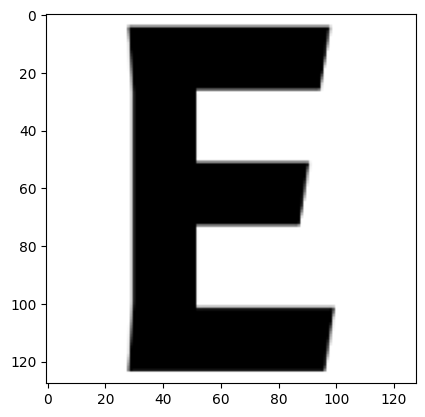

In [15]:
i = 4
plt.imshow(d['train'].dataset[i][0][0], cmap='gray')
print(d['train'].dataset[i][1])
print(d['train'].dataset[i][0][0].min(), d['train'].dataset[i][0][0].max())

# Parameters

In [6]:
device = 'cuda'
image_size = 64

channels = 1
unet_dim = 32
num_classes = 26
timesteps = 1000
unet_dim_mults = (1, 2, 4, 8,)
model_path = './weight/classifier_free_guidance.pth'

# define betas
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0) # alpha_var
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0) # [1. , *alphas_cumpprod[:-1]]
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
# 順方向の拡散過程
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod) # どのくらい元画像を残すか，徐々に小さくなる
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod) # どのくらいノイズを加えるか，徐々に大きくなる

# calculations for posterior q(x_{t-1} | x_t, x_0)
# 逆方向の拡散過程
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod) # sigma_t^2 どのくらいノイズを加えるか，徐々に小さくなる．非常に小さい

# forward diffusion (using the nice property)
@autocast(enabled = False)
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

@torch.no_grad()
def p_sample(model, x, classes, t, t_index, cond_scale=6., rescaled_phi=0.7):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    pred_noise = model.forward_with_cond_scale(x, t, classes, cond_scale=cond_scale, rescaled_phi=rescaled_phi)
    model_mean = sqrt_recip_alphas_t * (x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, classes, shape, cond_scale=6., rescaled_phi=0.7):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, classes, torch.full((b,), i, device=device, dtype=torch.long), i, cond_scale=cond_scale, rescaled_phi=rescaled_phi)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, classes, image_size, batch_size=16, channels=3, cond_scale=6., rescaled_phi=0.7):
    return p_sample_loop(model, classes, shape=(batch_size, channels, image_size, image_size), cond_scale=cond_scale, rescaled_phi=rescaled_phi)



# Load trained model

In [7]:
model = Unet(
    dim=unet_dim,
    channels=channels,
    dim_mults=unet_dim_mults,
    num_classes=num_classes,
    cond_drop_prob=0.5,
)
model.to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()


Unet(
  (init_conv): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1))
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=128, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=128, out_features=128, bias=True)
  )
  (classes_emb): Embedding(26, 32)
  (classes_mlp): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0-1): 2 x ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=256, out_features=64, bias=True)
        )
        (block1): Block(
          (proj): WeightStandardizedConv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 32, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): Block(
          (proj): WeightStandardi

# condition指定して生成

sampling loop time step: 100%|██████████| 1000/1000 [00:41<00:00, 24.39it/s]


IndexError: list index out of range

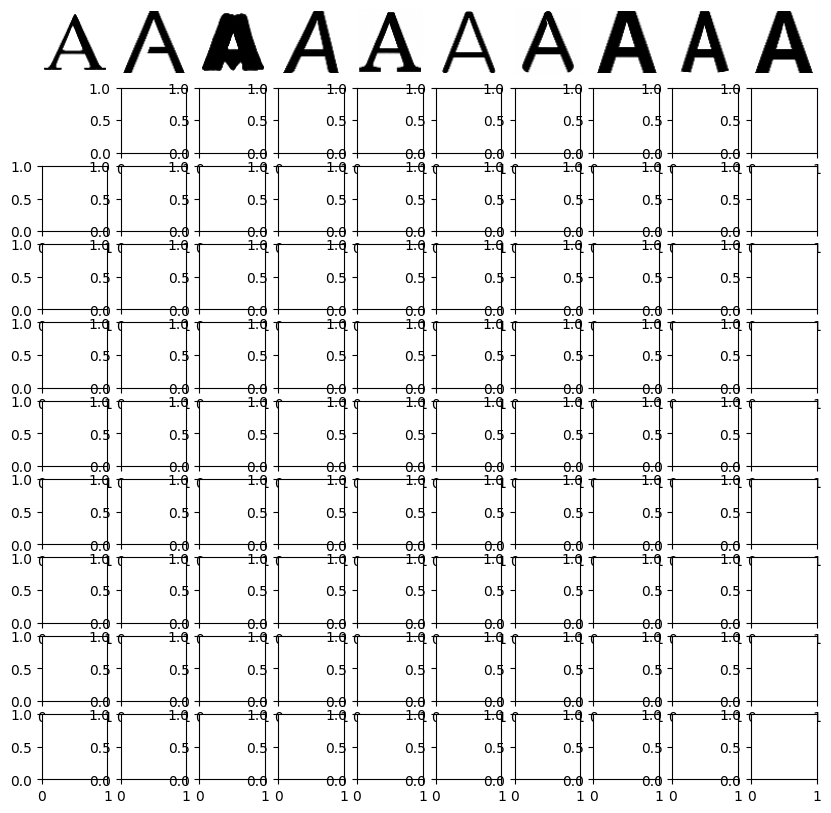

In [8]:
samples_list = []
for c in range(1):
    b = 10
    classes = torch.full((b,), c, device=device, dtype=torch.long)
    # sample 10 images
    samples = sample(model, classes, image_size=image_size, batch_size=b, channels=channels, cond_scale=6., rescaled_phi=0.7)
    samples_list.append(samples)

# show images
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(100):
    x = i // 10
    y = i % 10
    ax[x, y].axis("off")
    ax[x, y].imshow(samples_list[x][-1][y].reshape(image_size, image_size, channels), cmap="gray")